# A trial of [firecrown](https://firecrown.readthedocs.io/en/latest/_static/intro_article.html)

In this notebook we explore firecrown. A software package that allows us to build likelihoods based on a certain cosmological model defined by a set of parameters $\{\theta_{cosm}\}$

In the previous notebooks, we have investigated the matter power spectrum, angular power spectra and a basic, cutting-corners calculation of the sensitivity to neutrino parameters. The knowledge acquired in these will now be put to use. The elements that we investigated before will now serve as ingrdients to building a "likelihood". This in turn is an important ingredient for the Bayesian inference of the cosmologiical parameters through a statistical frameworks. (It provides DESC tools that are consistent and build up good results.)

Firecrown allows you to use the obtained likelihood for:
- cosmoSIS
- Cobaya
- NumCosmo
of which we will be using cosmoSIS later on. 

The main objects are:
- Cosmological model (parameters) [through [CCL](https://arxiv.org/abs/1812.05995)]
    CCL allows us to calculate any (theoretical) cosmological quantity. These wuantities are also essential to the likelihood but are calculated by CCL rather than firecrown.
- Modelling tools (haloprofile, perturbation theory, etc.)
    Firecrown provides a set of modelling tools that will be available next to CCL and will be updated to the "current cosmology". These modelling tools allow for additional analysis, like perturbaurion theory, haloprofiles, etc. Modelling tools link the cosmology to theoretical models that can be used to obtain the likelihod. Effectively this ensures that all different elements that go into the calculation of the likelihood are based on the same cosmology.
- Likelihoods
Typically, firecrown builds "Gaussian family" likelihoods, where the likelihood can be expressed as the distance between the expected and observed quantity of some observable. This Gaussian family of likelihoods take the form:
$$P(\vec{x}| \vec{\mu}, \~M) = f(\chi^{2})$$
$$\chi^{2} = \sum_{i, j}(x_{i} - mu_{i})^{T} M_{i, j} (x_{j} - mu_{j})$$
with:
$$\~M = \~C^{-1}$$
where **$\vec{\mu}_{i}$** is the theory vector, **$M_{i, j}$** the inverse of the covariance matrix $\left(\~C\right)$ and **$\vec{x}_{i}$** the datavector.

To initialize firecrown and obtain such a likelihood, we use a SACC file (Save All Correlations and Covariances). It is through the info in this SACC file that firecrown builds a likelihood that is written to be sampled by the statistical framework specified in the SACC file.

For building a Gaussian distribution, we require a datavector, a covariance matrix and a theory vector. Both the data vector and the covcariance matrix are passed through the SACC file. For the theory vector, firecrown gives the possibility to create a *statistic array*, which utilizes CCL. The statisic array can be generated by specifying certain *sources* to build correlations for example. Ohterwise, one cab also refer to the available statistic arrays within firecrown. The statistic array then calls upon the CCL objects and functions that can generate the theory vector.
The given sources will specify the statistic that is used as a theory vector for the generation of the likelihood. A Source references the underlying 'pyccl.Tracers' from CCL.

Firecrown also contains *systematics*. A systematic can be used to alter the theory vector by changing a certain aspect of the theory specifics, such as a shift in the galaxy distribution, etc.



In [1]:
# The required imports:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import yaml

# Some utitlity imports:
import math
import glass.observations
from scipy.stats import chi2

# For the firecrown examples:
import firecrown
import sacc
%matplotlib inline


# Building cosmological two-point likelihoods

The two-point framework is built up from "bin descriptors" which describe (a set of) observables and their properties. An example is *'InferredGalaxyZDist'*, describing the redshift distribution of galaxies in a single bin. The descriptors do not carry the informarion of the measurements directly, but they are defined as a common layer above the measurements. We can acces measurements like "counts", "shear" and "convergence" from these descriptors. This ensures that different measurements or components in the theory we are building, are based on identical descriptors  .

Bin descriptors can then be combined using the *TwoPointXY* to cross-correlate two bins. The two-point framework is separated in a real space and a harmonic space part, represented by *'TwoPointReal'* and *'TwoPointHarmonic'*, respectively. The real space measurement is a function of angular separation $\theta$, while the harmonic space counterpart is a function of multipole $\ell$ following the expansion in sperical harmonics **[$\todo{link to notebook #2?}$]()**
These objects do not require actual data to describe the arrangement of the data, such that they allow for forecasting, which is of great relevance to this study.

For our case, we consider the TwoPointHarmonic, so let us take this as a baseline from here.
The TwoPointHarmonic is then taken as an entry to *'TwoPointMeasurement'*, together with observational data or mock data(the latter in the case of a forecast).

To build a likelihood or obtain theoretical predictions from this, we must create a TwoPoint object that contains:
- TwoPointMeasurement
- TwoPointHarmonic

This is combined into a TwoPoint object by *'TwoPointFactory'* which also takes the modelling choices and generates the TwoPoint object based on these entries.

Let us now take a closer look at these elements that make up each step of the process described above, shown in the folowing diagram:

| ![alt text](/home/xander/Masters-Project/Outputs/Setup_results/Firecrown_TwoPoint_framework.png) |
|:--:|

source: [Firecrown's Two-Point Framework](https://firecrown.readthedocs.io/en/latest/_static/two_point_framework.html#fig-framework-hierarch)

Now we will turn to the more elaborate examples and run through the examples of each of the specific elements of the Two-Point Framework. First of alll, we will explain the element and then put it to use.

### Small rundown, followong the tutorial: [Inferred Redshift Distribution](https://firecrown.readthedocs.io/en/latest/_static/inferred_zdist.html)

#### Redshift distribution
An example of a bin descriptor, like mentioned above, is the galaxy redshift distribution: InferredGalaxyZDist. Using InferredGalaxyZDist we can describe the galaxy redshift distribution in a (photometric) redshift bin. We can define the Galaxy redshift distribution through the SACC file, as we extract the informations out of it; or we can define the galaxy redshift distribution using the built-in functionalities of Firecrown.  

In [ ]:
# First we import the corresponding functions from the firecrown module:
from firecrown.metadata_types import Galaxies, InferredGalaxyZDist

# Taking the photometric redshiftbin:
z = np.linspace(0.0, 1.0, 200)

# Define the redshift distribution:
lens_0 = InferredGalaxyZDist(
    bin_name = "lens_0",
    z = z,
    dndz = np.exp(-0.5 * ((z - 0.5)/0.02) **2) / np.sqrt(2 * np.pi) / 0.02, 
    measurements = {Galaxies.COUNTS},
)

#### Correlating the bins
Now that we created the redshift distribution in the redhiftbin defined by z, we can (cross-)correlate the bin with another one.
Since we only defined one redshift bin lens_0, we define the auto correlation. 

After this we can build the two-point correlation function based on the correlated bins.

In [ ]:
from firecrown.metadata_types import TwoPointXY, TwoPointHarmonic, TwoPointReal, Measurement
from firecrown.generators.two_point import LogLinearElls

lens_0_auto = TwoPointXY(
    x = lens_0,
    y = lens_0,
    x_measurement = Galaxies.COUNTS,
    y_measurement = Galaxies.COUNTS,
)

# Since we are defining the auto-correlation in harmnonic space, we first define the multipoles:
ells_generator = LogLinearElls(minimum=2, midpoint=20, maximum=200, n_log=20)

# The angular power spectrum of the auto-correlated bins:
lens_0_auto_harmonic = TwoPointHarmonic(XY=lens_0_auto, ells=ells_generator.generate())

# Note that the formulation of TwoPointXY also allows us to define the real space correlation function or the TwoPointCWindow from the same formulation of TwoPointXY. For some angles:4
theta = np.linspace(0.01, 10.0, 100)
real_space = TwoPointReal(XY=lens_0_auto, thetas=theta)


#### Theory prediction Two Point Object

Next up, we can create the TwoPoint object from the angular power spectrum we defined above.
Note that we do not include any measurements or observations by calling TwoPointMeasurement before defining the 
TwoPoint object

We are thus generating a theoretical model.

In [ ]:
from firecrown.likelihood.two_point import (
    TwoPoint,
    TwoPointFactory,
    NumberCountsFactory,
)
from firecrown.metadata_types import TwoPointCorrelationSpace

# Now we generate the two-point objects based on the angular power spectrum, using the NumberCountsFactory.
all_two_points = TwoPoint.from_metadata(
    [lens_0_auto_harmonic], 
    tp_factory = TwoPointFactory(
        correlation_space  = TwoPointCorrelationSpace.HARMONIC,
        number_counts_factories = [NumberCountsFactory(global_systematics=[], per_bin_systematics=[])],
        ),
)

tp_harmonic = all_two_points[0]

ImportError: cannot import name 'TwoPointFactory' from 'firecrown.likelihood.two_point' (/home/xander/anaconda3/envs/next_cclenv/lib/python3.12/site-packages/firecrown/likelihood/two_point.py)

In [ ]:
"""
Our theoretical model could require us to add and specify additional parameters:

Note that this set of parameters is not set and fixed. We can alter the values and update this later on
"""
from firecrown.parameters import ParamsMap

# Find the required paramters. In our case this is just one prameter
req_pars = tp_harmonic.required_parameters()
default_pars = req_pars.get_default_values() # This generates a dictionary with the default values for the parameters
pars = ParamsMap(default_pars)

NameError: name 'tp_harmonic' is not defined

In [ ]:

"""
Now that we create the TwoPoint object, we can specify the cosmological model and the statistics of the analysis
"""
from firecrown.modeling_tools import ModelingTools
from firecrown.ccl_factory import CCLFactory
from firecrown.updatable import get_default_params_map
from plotnine import *

# First we specify the modelling tools and cosmology on which we ebuild the TwoPoint object:
tools = ModelingTools(ccl_factory=CCLFactory(require_nonlinear_pk=True))
params = get_default_params_map(tools, tp_harmonic)

# Now calculate the theory vector:
tools.update(params)
tools.prepare()
tp_harmonic.update(params)
theory_vector = tp_harmonic.compute_theory_vector(tools)

# When we plot the theory vector:
data =  pd.DataFrame(
    {
        "ell": tp_harmonic.ells,
        "C_ell": theory_vector,
        "bin-x": lens_0_auto_harmonic.XY.x.bin_name,
        "bin-y": lens_0_auto_harmonic.XY.y.bin_name,
        "measurements": lens_0_auto_harmonic.get_sacc_name(),
    }
)

(
    ggplot(data, aes(x="ell", y="C_ell"))
    + geom_point()
    + geom_line()
    + labs(x=r"$\ell$", y=r"$C_\ell$")
    + scale_x_log10()
    + scale_y_log10()
    # + doc_theme()
)

NameError: name 'tp_harmonic' is not defined

## Bin descriptors

Bin descriptors are dataclasses and form the first element and basis of the Two-Point framework. The bin descriptors contain all the information to describe indivifual bins. 

For example: let us consider the bin descriptor InferredGalaxyZDist we have used in the 'Small rundown' above, the bin characteristics that will be taken from this information are:
- The bin name: *'InferredGalaxyZDist.bin_name'*
- The redshift of the bin: *'InferredGalaxyZDist.z'*
- The Galaxy distribution as a function of redshift, within the bin: *'' InferredGalaxyZDist.dndz*

Next to the bin characteristics, we can also find certain measurements in the (basic) bin descriptors:
- *'Galaxies.COUNTS'*
- *'Galaxies.SHEAR_T'*
- *'CMB.CONVERGENCE'*

These will idicate the type of measurement within the bin. Note that it is possible to include multiple measurement types per bin.
Beside the measurement types, we can also distinguish between different subpopulations within a single measurement type, within a certain bin. We can do this through: *'InferredGalaxyZDist.type_source'* which is a 'string'. For example: for the case of CMB lensing, InferredGalaxyZDist.type_source might refer to Planck or SPT date.
In doing this, we can distinguish between the theretical modelling that is applied and the set of nuisance parameters, etc.

Overall, using the bin descriptors, we define the redshift distributions in a specific photometric redshift bin, the tracer types, etc. From theses bins, we build up the rest of the Two-Point Framework.

NOTE: through *'TwoPointTracerSpec'*, we can initiate tracers more directly instead of using the arguments in the bin descriptors

### [ZDistLSSTSRD](https://firecrown.readthedocs.io/en/latest/_static/inferred_zdist_generators.html)
Alternatively to the InferredGalaxyZDist, we can also generate galaxy redshift distributions that can be better incorporated with the format of LSST Science Requirements Document (SRD). 

To align the galaxy redshift distribution with the LSST SRD format, we define the distribution of galaxies through a probability distribution function $\left(P(z | B_{i}, \theta)\right)$:
$$P (z | B_{i}, \theta) = \frac{dn}{dz}(z; B_{i}, \theta) $$

where $B_{i}$ is the i-th photometric redshift bin and $\theta$ the parameters that define our model.
Using ZDistLSSTSRD, we create a similar object to when we use InferredGalaxyZDist. This object then also contains similar info: the redshifts, the probability distribution function for these redshifts and the specified measurement data-types.

In the LSST SRD case, the probability distribution function can be written as:
$$P(z | \theta) = f(z; \alpha, \beta, z_{0}) = \frac{\alpha}{z_{0}\Gamma[(1 + \beta)/\alpha]} \left(\frac{z}{z_{0}}\right)^{\beta} exp\left[\left(\frac{z}{z_{0}}\right)^{\alpha}\right]$$

To obtain the redshift distribution for each bin, we must convolve the general redshift distribution function written above with the error on the photometric redshift:

$$P(z_{p} | z, \sigma_{z}) = \frac{1}{N(z)\sqrt{2 \pi} \sigma_{z}(1 + z)} exp\left[\frac{-1}{2}\left(\frac{(z - z_{p})^{2}}{\sigma_{z}^{2}(1 + z)^{2}}\right){\alpha}\right]$$

with;

$$N(z) = \frac{1}{2} erfc\left[-\frac{z}{\sqrt{2}\sigma_{z}(1 + z)}\right]$$

Using these, we can write the general galaxy redshift distribution we started with as:
$$
\begin{aligned}
P(z | B_{i}, \theta) &= \int^{z^{up}_{p, i}}_{z^{low}_{p, i}} dz_{p}  P(z_{p} | z, \sigma_{z}) P(z | \theta) \\
&= \int^{z^{up}_{p, i}}_{z^{low}_{p, i}} dz_{p} \frac{1}{\sqrt{2\pi}\sigma_{z}(1 + z)}exp\left[\frac{-1}{2}\left(\frac{(z - z_{p})^{2}}{\sigma_{z}^{2}(1 + z)^{2}}\right){\alpha}\right] f(z; \alpha, \beta, z_{0})
\end{aligned}
$$

with $B_{i} = \left(z^{low}_{p, i}, z^{up}_{p, i}, \sigma_{z}\right)$ defines the photometric bins and $\sigma_{z}(1 + z)$ gives the error in the photometric redshifts.

We can now define the galazy redshift distriburtion in the LSST SRD format. To do this we will refer to the year and year 10 data. We choose a redshift space of 100 equally spaced increments between the redshifts $0 < z < 3.5$:

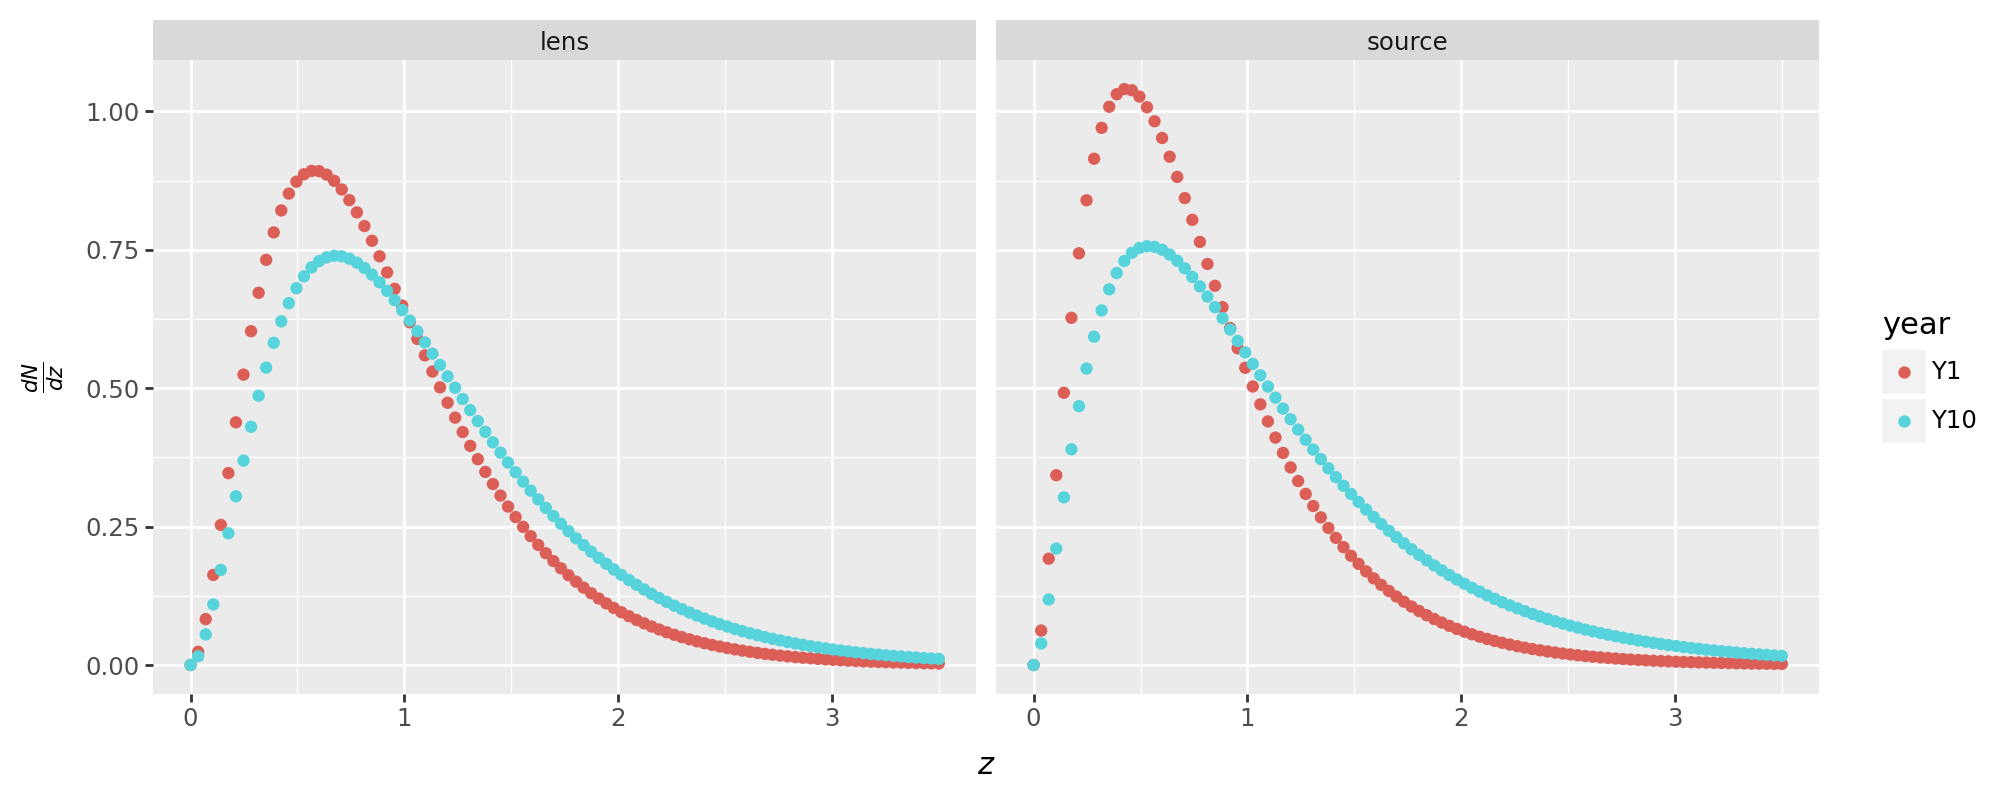

In [ ]:
from firecrown.generators.inferred_galaxy_zdist import ZDistLSSTSRD

lsst_z = np.linspace(0.0, 3.5, 100)

# Now we will evaluate the redshift distribution of the LSST SRD using year 1 and year 10 data. We will do this for lens and source galaxies
# since LSST is mainly used for WL observations:
zdist_year1_lens = ZDistLSSTSRD.year_1_lens(use_autoknot=True, autoknots_reltol=1.0e-5) # autoknots (NumConsmo) determines the number of knots in the spline interpolation
zdist_year10_lens = ZDistLSSTSRD.year_10_lens(use_autoknot=True, autoknots_reltol=1.0e-5)

zdist_year1_source = ZDistLSSTSRD.year_1_source(use_autoknot=True, autoknots_reltol=1.0e-5)
zdist_year10_source = ZDistLSSTSRD.year_10_source(use_autoknot=True, autoknots_reltol=1.0e-5)

# Look at the redshift probability distributions:
Pz_year1_lens = zdist_year1_lens.distribution(z=lsst_z)
Pz_year10_lens = zdist_year10_lens.distribution(z=lsst_z)

Pz_year1_source = zdist_year1_source.distribution(z=lsst_z)
Pz_year10_source = zdist_year10_source.distribution(z=lsst_z)

# Plot the redshift distributions:
d_y_all = pd.concat(
    [
        pd.DataFrame(
            {
                "z": lsst_z,
                "Pz": Pz,
                "year": year,
                "distribution": dist,
            }
        )
        for Pz, year, dist in [
                (Pz_year1_lens, "Y1", "lens"),
                (Pz_year10_lens, "Y10", "lens"),
                (Pz_year1_source, "Y1", "source"),
                (Pz_year10_source, "Y10", "source"),
        ]
    ]
)

(
    ggplot(d_y_all, aes(x="z", y="Pz", color="year"))
    + geom_point()
    + labs(x=r"$z$", y=r"$\frac{dN}{dz}$")
    # + doc_theme()
    + facet_wrap("~ distribution", ncol=2)
    + theme(figure_size=(10, 4))
)

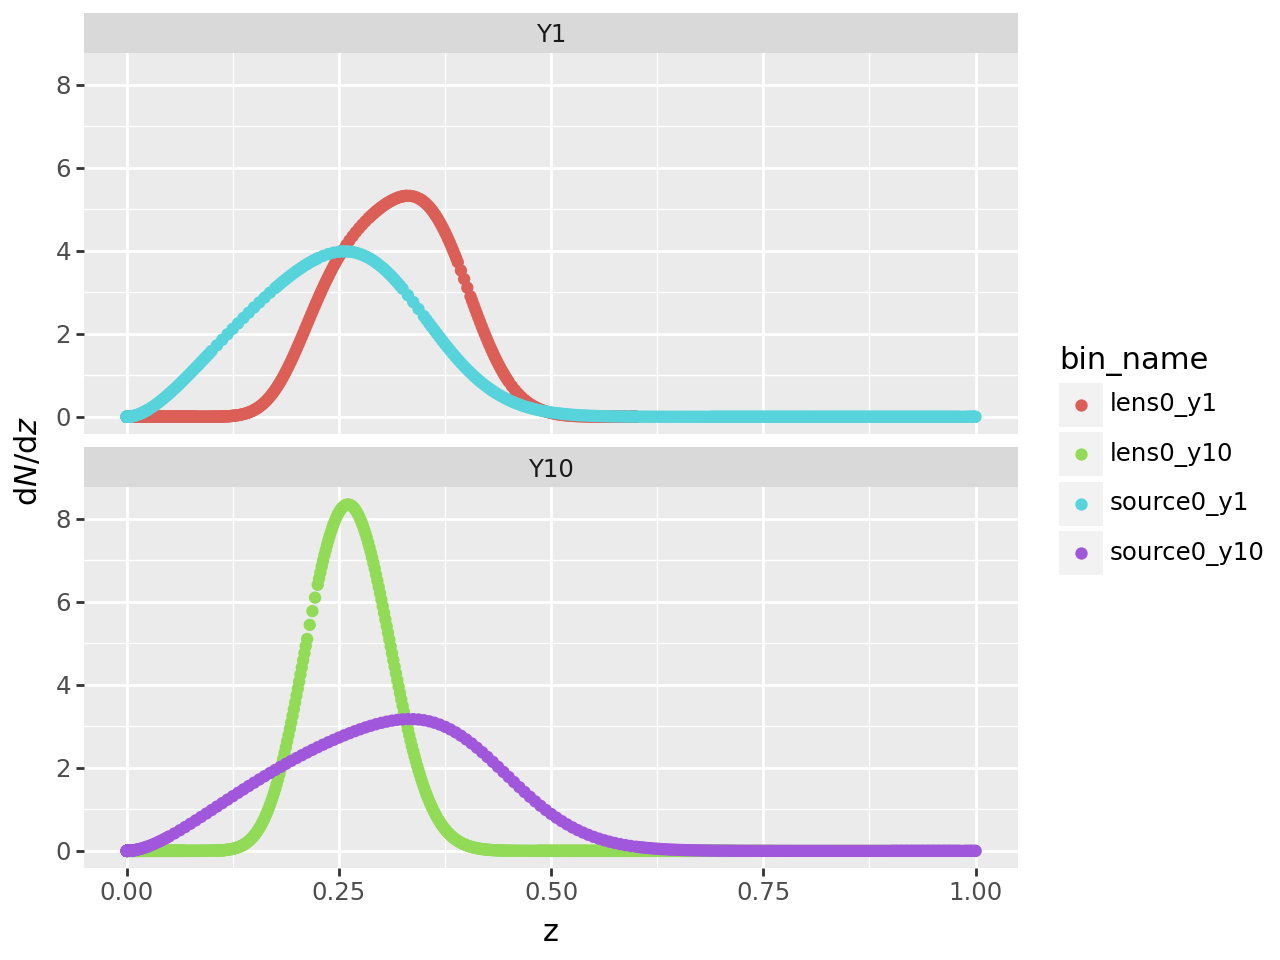

In [ ]:
"""
Try to create a InferredGalaxyZDist object using the LSST SRD redshift distributions. Look at the redshift space 0 < z < 0.6, and incorporate the error in
the phototmetric redshift(sigma_z) througha resolution parameter.
"""
from firecrown.generators.inferred_galaxy_zdist import (
    Y1_LENS_BINS,
    Y10_LENS_BINS,
    Y1_SOURCE_BINS,
    Y10_SOURCE_BINS,
)

partial_lsst_z = np.linspace(0, 0.6, 100)

# Now we create the InferredGalaxyZDist objects
Pz_lens0_y1 = zdist_year1_lens.binned_distribution(
    zpl=Y1_LENS_BINS["edges"][0],
    zpu=Y1_LENS_BINS["edges"][1],
    sigma_z=Y1_LENS_BINS["sigma_z"],
    z=partial_lsst_z,
    name="lens0_y1",
    measurements={Galaxies.COUNTS},    
)
Pz_source0_y1 = zdist_year1_source.binned_distribution(
    zpl=Y1_SOURCE_BINS["edges"][0],
    zpu=Y1_SOURCE_BINS["edges"][1],
    sigma_z=Y1_SOURCE_BINS["sigma_z"],
    z=z,
    name="source0_y1",
    measurements={Galaxies.SHEAR_E},
)
Pz_lens0_y10 = zdist_year10_lens.binned_distribution(
    zpl=Y10_LENS_BINS["edges"][0],
    zpu=Y10_LENS_BINS["edges"][1],
    sigma_z=Y10_LENS_BINS["sigma_z"],
    z=z,
    name="lens0_y10",
    measurements={Galaxies.COUNTS},
)
Pz_source0_y10 = zdist_year10_source.binned_distribution(
    zpl=Y10_SOURCE_BINS["edges"][0],
    zpu=Y10_SOURCE_BINS["edges"][1],
    sigma_z=Y10_SOURCE_BINS["sigma_z"],
    z=z,
    name="source0_y10",
    measurements={Galaxies.SHEAR_E},
)

# Next we check that the objects we created are of the expected type.
assert isinstance(Pz_lens0_y1, InferredGalaxyZDist)
assert isinstance(Pz_lens0_y10, InferredGalaxyZDist)
assert isinstance(Pz_source0_y1, InferredGalaxyZDist)
assert isinstance(Pz_source0_y10, InferredGalaxyZDist)

# Visualized:
d_lens0_y1 = pd.DataFrame(
    {
        "z": Pz_lens0_y1.z,
        "dndz": Pz_lens0_y1.dndz,
        "year": "Y1",
        "bin_name": Pz_lens0_y1.bin_name,
    }
)
d_source0_y1 = pd.DataFrame(
    {
        "z": Pz_source0_y1.z,
        "dndz": Pz_source0_y1.dndz,
        "year": "Y1",
        "bin_name": Pz_source0_y1.bin_name,
    }
)
d_lens0_y10 = pd.DataFrame(
    {
        "z": Pz_lens0_y10.z,
        "dndz": Pz_lens0_y10.dndz,
        "year": "Y10",
        "bin_name": Pz_lens0_y10.bin_name,
    }
)
d_source0_y10 = pd.DataFrame(
    {
        "z": Pz_source0_y10.z,
        "dndz": Pz_source0_y10.dndz,
        "year": "Y10",
        "bin_name": Pz_source0_y10.bin_name,
    }
)
data = pd.concat([d_lens0_y1, d_source0_y1, d_lens0_y10, d_source0_y10])

(
    ggplot(data, aes("z", "dndz", color="bin_name"))
    + geom_point()
    + labs(y=r"$\frac{dN}{dz}$"")
    # + doc_theme()
    + facet_wrap("~ year", nrow=2)
)


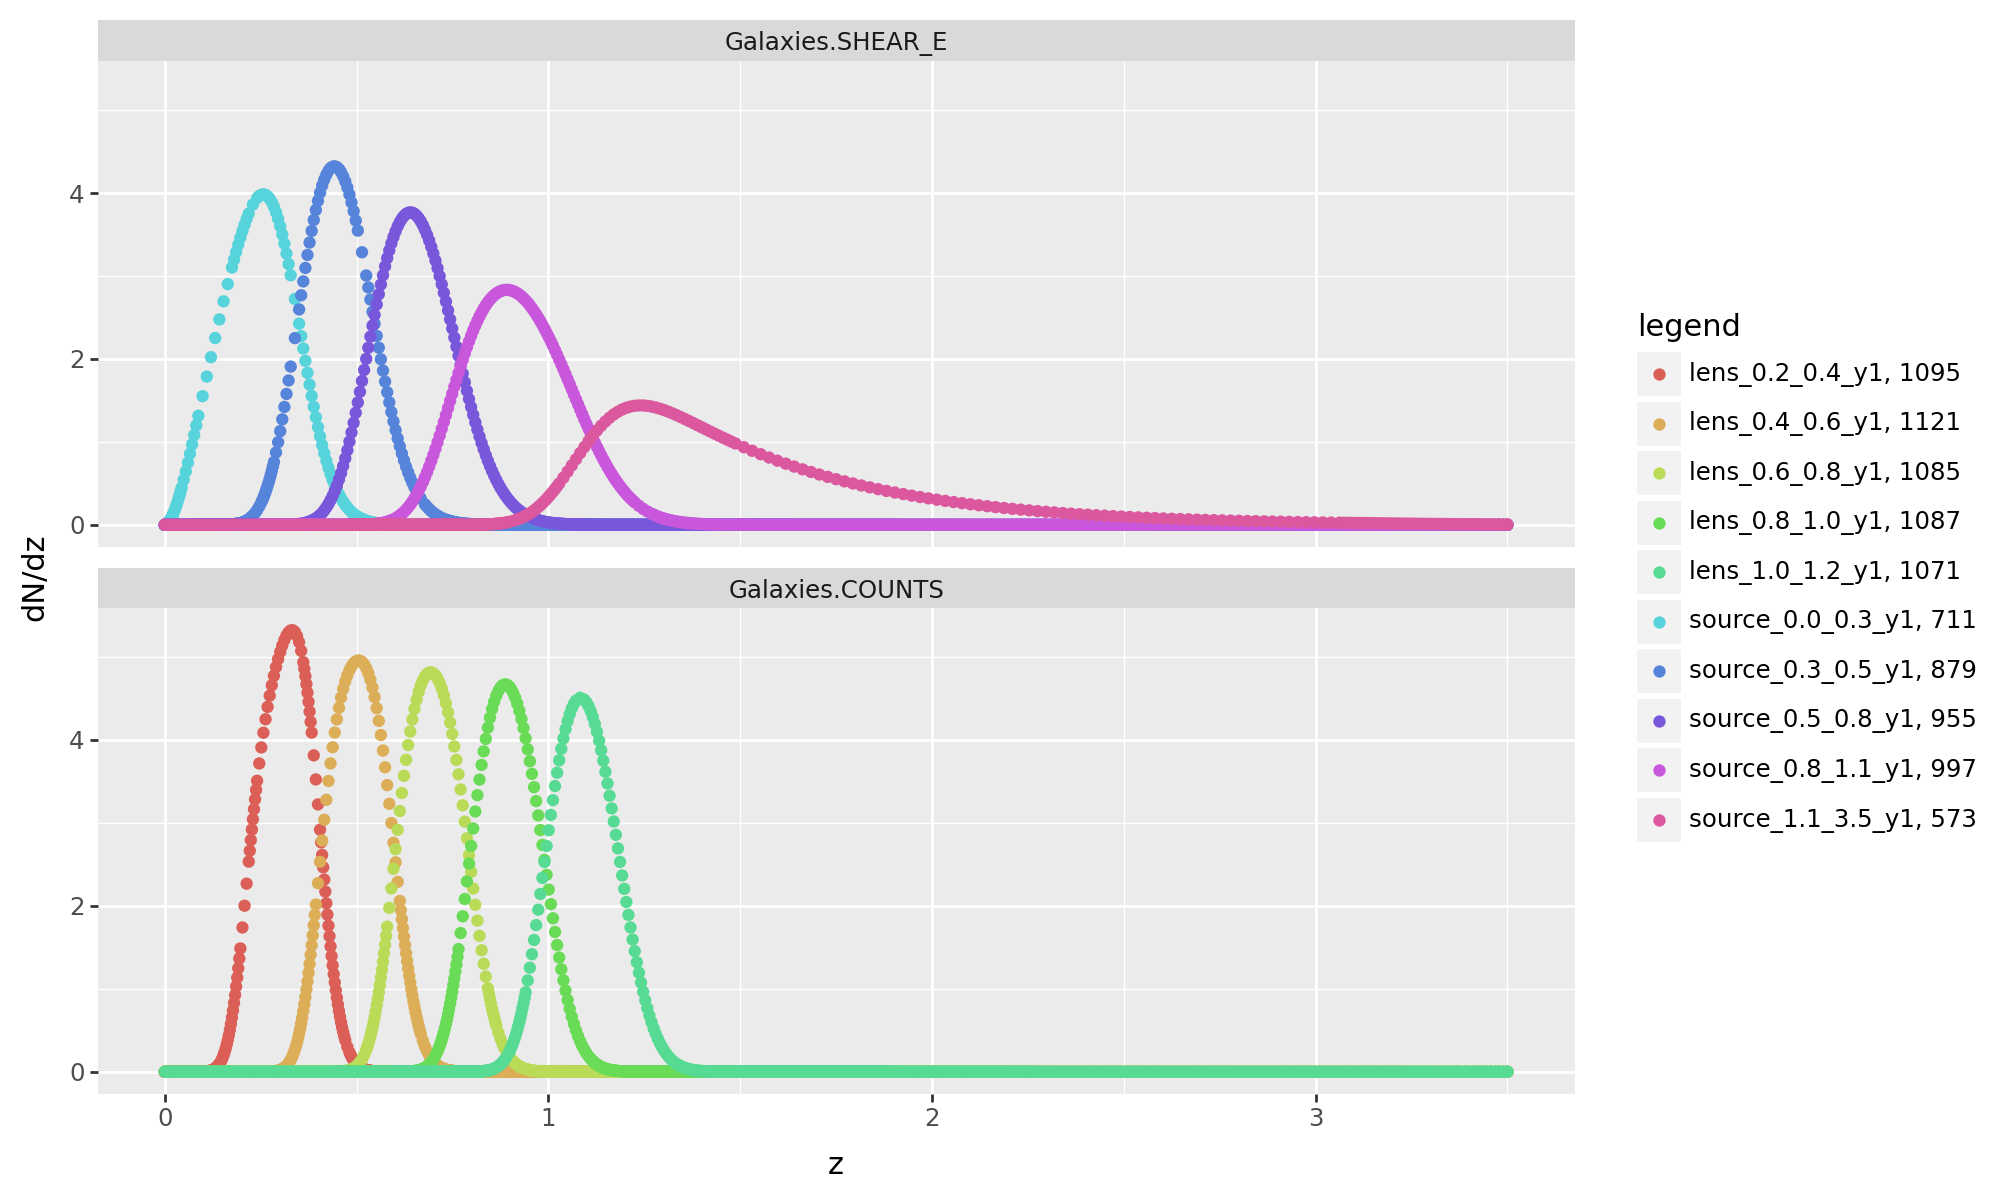

In [ ]:
"""
Instead of focussing on 1 photometric redshiftbin, we can also use the ZDistLSSTSRD to create a set of InferredGalaxyZDist objects for all bins at once:

We do this for the year 1 data below and plot both the Weak Lensing and the Galaxy clustering phototmetric redshift distributions.
"""
from itertools import pairwise

all_y1_bins = [
    zdist_year1_lens.binned_distribution(
        zpl=zpl,
        zpu=zpu,
        sigma_z=Y1_LENS_BINS["sigma_z"],
        z=lsst_z,
        name=f"lens_{zpl:.1f}_{zpu:.1f}_y1",
        measurements={Galaxies.COUNTS},
    )
    for zpl, zpu in pairwise(Y1_LENS_BINS["edges"])
] + [
    zdist_year1_source.binned_distribution(
        zpl=zpl,
        zpu=zpu,
        sigma_z=Y1_SOURCE_BINS["sigma_z"],
        z=lsst_z,
        name=f"source_{zpl:.1f}_{zpu:.1f}_y1",
        measurements={Galaxies.SHEAR_E},
    )
    for zpl, zpu in pairwise(Y1_SOURCE_BINS["edges"])
]

# In a plot:
d_y1 = pd.concat(
    [
        pd.DataFrame(
            {
                "z": Pz.z,
                "dndz": Pz.dndz,
                "bin": Pz.bin_name,
                "measurement": list(Pz.measurements)[0],
                "legend": f"{Pz.bin_name}, {len(Pz.z)}",
            }
        )
        for Pz in all_y1_bins
    ]
)

(
    ggplot(d_y1, aes("z", "dndz", color="legend"))
    + geom_point()
    + labs(y=r"$\frac{dN}{dz}$")
    + facet_wrap("~ measurement", nrow=2)
    # + doc_theme()
    + theme(figure_size=(10, 6))
)

The binning process within the ZDistLSSTSRD is different for both the lens and source galaxies. For the lens galaxies, the binning is initiated by specifying bin edges, therefore we can control the area within the bins. For the source galaxies, the binning makes sure that there are equal numbers of galaxies in each bin.
(One can use the function equal_area_bins in ZDistLSSTSRD. However, this does require some careful details)

Another complicating factor is the fact that the total galaxy redshift distribution is a convolution of the true galaxy redshift distribution with the error in the photometric redshift. This way we cannot simply generate the photometric redshift bins. To actually do so we would need to:
- Generate the true redshift distribution
- Convolve the true redshift distribution with the error in the photometric redshift (to obtain the final galaxy redshift distribution)
- Define the bin edges using a cumulative distribution function (CDF); to define photometric redshift bins with equal galaxy counts.

To avoid this procedure, we can use an approximation in the equal_area_bins with "use_true_distribution=True". This bases the bins on the true galaxy redshift distribution insteead of the final galaxy redshift distribution.

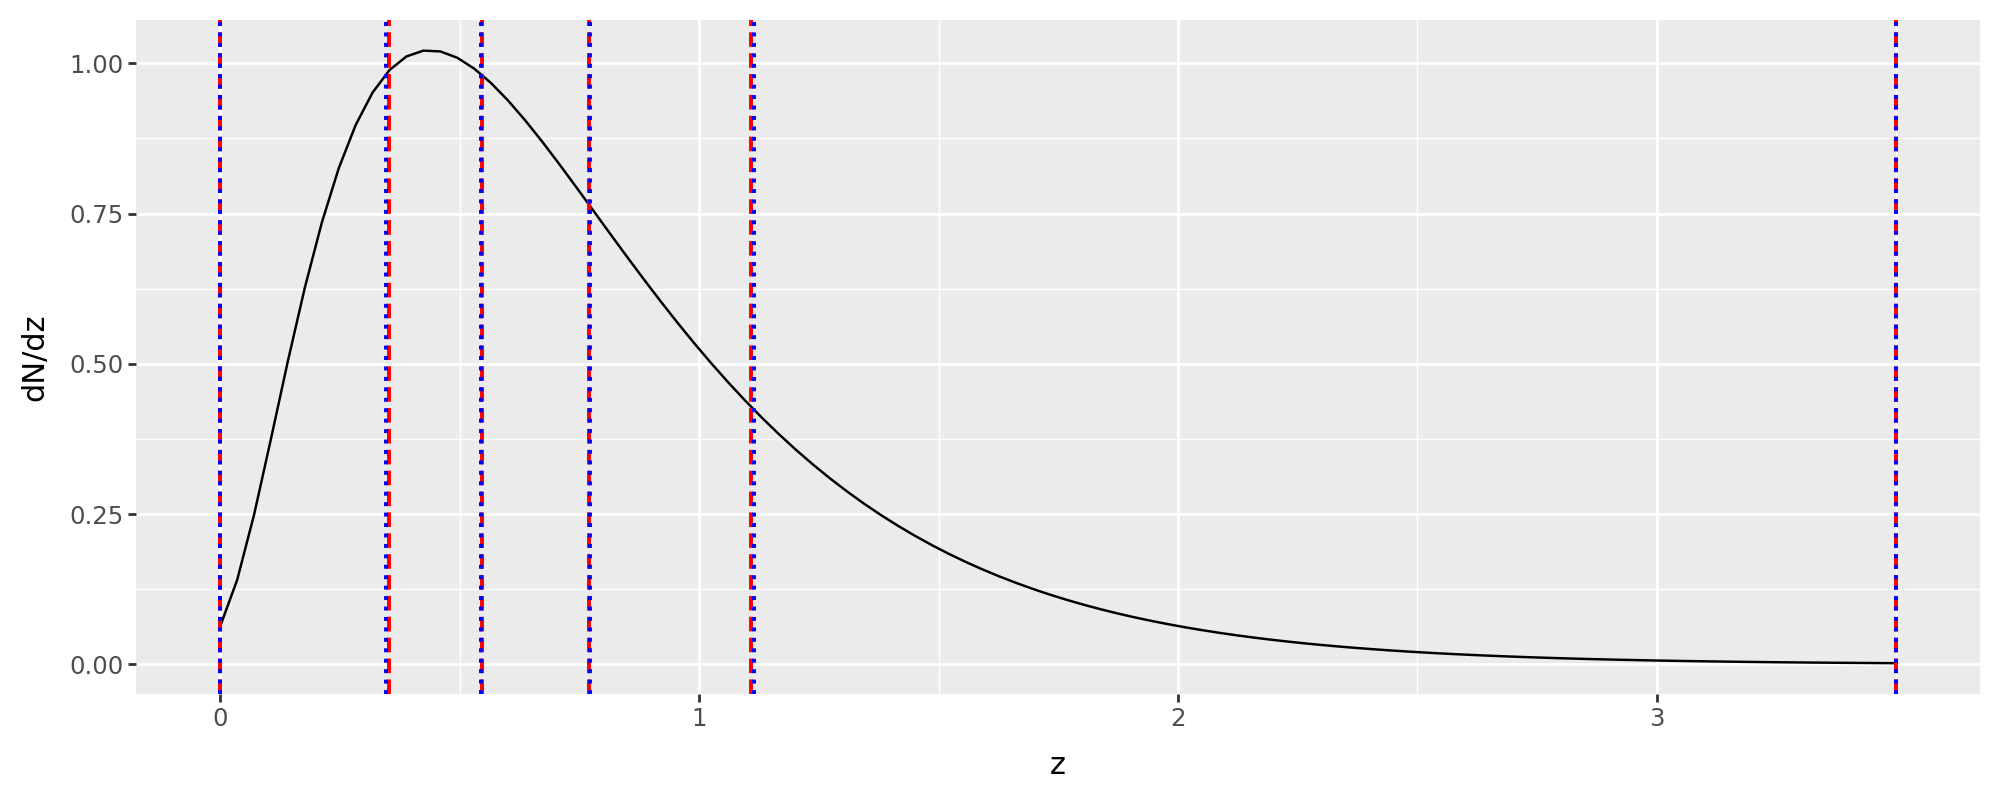

In [ ]:
"""
Look at the approximate result, when we use the true galaxy redshift distribution to generate the source bins, for the year 1 data of LSST:
"""
# We use the same zdist_y1_source that was created above.
# Next, we generate the source bins using the true distribution.
source_bins = zdist_year1_source.equal_area_bins(
    n_bins=5, sigma_z=Y1_SOURCE_BINS["sigma_z"], use_true_distribution=True, last_z=3.5
)

# Now we do the same, but using the photometric distribution.
source_bins_phot = zdist_year1_source.equal_area_bins(
    n_bins=5, sigma_z=Y1_SOURCE_BINS["sigma_z"], use_true_distribution=False, last_z=3.5
)

stats = zdist_year1_source.compute_distribution(Y1_SOURCE_BINS["sigma_z"])
dndz = np.array([stats.eval_p(z_i) for z_i in lsst_z])

d_source_bins = pd.DataFrame({"z": lsst_z, "dndz": dndz})

# Create DataFrames for the bin edges
d_bin_edges = pd.DataFrame({"bin_edges": source_bins})
d_bin_edges_phot = pd.DataFrame({"bin_edges_phot": source_bins_phot})

(
    ggplot(d_source_bins, aes("z", "dndz"))
    + geom_line()
    + geom_vline(
        data=d_bin_edges,
        mapping=aes(xintercept="bin_edges"),
        color="red",
        linetype="dashed",
        size=0.8,
    )
    + geom_vline(
        data=d_bin_edges_phot,
        mapping=aes(xintercept="bin_edges_phot"),
        color="blue",
        linetype="dotted",
        size=0.8,
    )
    + labs(y=r"$\frac{dN}{dz}$")
    # + doc_theme()
    + theme(figure_size=(10, 4))
)

In [ ]:
"""
To demonstrate the accuracy of this approximation, we set up the following table:
"""
N_total = stats.eval_pdf(3.5)
N_gal = np.array(
    [
        (stats.eval_pdf(zu) - stats.eval_pdf(zl)) / N_total
        for zl, zu in pairwise(source_bins)
    ]
)
N_gal_phot = np.array(
    [
        (stats.eval_pdf(zu) - stats.eval_pdf(zl)) / N_total
        for zl, zu in pairwise(source_bins_phot)
    ]
)
percent_diff = 100.0 * (N_gal - N_gal_phot) / N_gal
(
    pd.DataFrame(
        {
            "True Distribution Bin": [
                f"({i:.3f}, {j:.3f})" for i, j in pairwise(source_bins)
            ],
            "Photometric Distribution Bin": [
                f"({i:.3f}, {j:.3f})" for i, j in pairwise(source_bins_phot)
            ],
            "Galaxies (True Dist.)": [f"{n:.3f}" for n in N_gal],
            "Galaxies (Photometric Dist.)": [f"{n:.3f}" for n in N_gal_phot],
            "Percent Difference (%)": [f"{p:.1f}%" for p in percent_diff],
        }
    )
)

,True Distribution Bin,Photometric Distribution Bin,Galaxies (True Dist.),Galaxies (Photometric Dist.),Percent Difference (%)
0,"(0.000, 0.352)","(0.000, 0.347)",0.205,0.200,2.6%
1,"(0.352, 0.547)","(0.347, 0.545)",0.196,0.200,-1.8%
2,"(0.547, 0.771)","(0.545, 0.772)",0.197,0.200,-1.4%
3,"(0.771, 1.109)","(0.772, 1.114)",0.199,0.200,-0.7%
4,"(1.109, 3.500)","(1.114, 3.500)",0.202,0.200,1.1%


### [Serialization](https://firecrown.readthedocs.io/en/latest/_static/inferred_zdist_serialization.html)

We can serialize the objects InferredGalaxyZDist and ZDistLSSTSRD to disk. This makes us able to read them back into Firecrown. The resulting files can then also be edited and stored, to provide a controlled way of changing and storing redshift distributions.
In principle, this will also make these objects readable to the human interpretation, however this is not as simple as is sounds. For the object InferrredGalaxyZDist, we must serialize the parameters we use to set it up. Serializing the object itself, yields a file which we can humanly not interpret. 

The best way of going about the serializing the objects is to serialize the parameters. To do so, we can target the dataclasses *'ZDistLSSTSRDBin'* & *'ZDistLSSTSRDBinCollection'*, which contain all the parameters used to define the galaxy redshoft distribution objects.

We will now go through the serialization of the ZDistLSSTSRDBin and ZDistLSSTSRDBinCollection dataclasses and use the resulting file to read in the galaxy redshift distribution.

In [ ]:
"""
Start by serializing the ZDistLSSTSRDBin dataclass, for which we will generate a YAML file that contains the serialized parameters
For the ZDistLSSTSRDBin dataclass we need to make sure that the redshift is serialized.
"""
from firecrown.generators.inferred_galaxy_zdist import ZDistLSSTSRDBin, LinearGrid1D, RawGrid1D
from firecrown.utils import base_model_to_yaml

# To serialize the resdhift, we create a linear grid: (One can also use RawGrid1D)
serial_z = LinearGrid1D(start=0.01, end=0.5, num=20)

# Define the galaxy redshift distribution object we want to serialize:
bin0 = ZDistLSSTSRDBin(
    zpl=0.1, 
    zpu=0.2,
    sigma_z=0.03,
    z=serial_z,
    bin_name="bin0", 
    measurements={Galaxies.COUNTS},
    )

bin0_yaml = base_model_to_yaml(bin0)

print(bin0_yaml)

zpl: 0.1
zpu: 0.2
sigma_z: 0.03
z: {start: 0.01, end: 0.5, num: 20}
bin_name: bin0
measurements:
- {subject: Galaxies, property: COUNTS}



In [ ]:
"""
Now we turn to the ZDistLSSTSRDBinCollection dataclass.
Similarly to before, we define a bin with serialized parameters and write out the object parameters to a YAML file.
"""
from firecrown.generators.inferred_galaxy_zdist import (
    ZDistLSSTSRDBinCollection,
    Y1_LENS_ALPHA,
    Y1_LENS_BETA,
    Y1_LENS_Z0,
)

# To generalize the procedure, we add bin1 to the above defined bin0. To do so we use the definition of bin0:
d = bin0.model_dump()
d.update(bin_name="bin1", zpl=0.2, zpu=0.3)
bin1 = ZDistLSSTSRDBin.model_validate(d)

# Define the ZDistLSSTSRDBinCollection object, containing the two bins we defined above.
bin_collection = ZDistLSSTSRDBinCollection(
    alpha = Y1_LENS_ALPHA,
    beta = Y1_LENS_BETA,
    z0 = Y1_LENS_Z0,
    bins = [bin0, bin1],
)

bin_collection_yaml = base_model_to_yaml(bin_collection)
print(bin_collection_yaml)

alpha: 0.94
beta: 2.0
z0: 0.26
bins:
- zpl: 0.1
  zpu: 0.2
  sigma_z: 0.03
  z: {start: 0.01, end: 0.5, num: 20}
  bin_name: bin0
  measurements:
  - {subject: Galaxies, property: COUNTS}
- zpl: 0.2
  zpu: 0.3
  sigma_z: 0.03
  z: {start: 0.01, end: 0.5, num: 20}
  bin_name: bin1
  measurements:
  - {subject: Galaxies, property: COUNTS}
max_z: 5.0
use_autoknot: true
autoknots_reltol: 0.0001
autoknots_abstol: 1.0e-15



In [ ]:
"""
Now we will look at reading back the serialized information from the YAML file and generate the corresponding galaxy redshift distribution objects:

This is done in two steps:
1. Read in the YAML file using 'base_model_from_yaml' function from the 'firecrown.utils'
2. Generate the distribution from the object containing the serialized parameters
    This makes that for each bin, we have the following:
    - An array of redshfts
    - An array with the corresponding dN/dz values
"""
from firecrown.utils import base_model_from_yaml
from pprint import pprint

# Read the data into:
bin_collection_read = base_model_from_yaml(
    ZDistLSSTSRDBinCollection, bin_collection_yaml
)

assert bin_collection.alpha == bin_collection_read.alpha
assert bin_collection.beta == bin_collection_read.beta
assert bin_collection.z0 == bin_collection_read.z0
assert len(bin_collection.bins) == 2
assert bin_collection.bins[0].zpl == bin_collection_read.bins[0].zpl
assert bin_collection.bins[0].zpu == bin_collection_read.bins[0].zpu
assert bin_collection.bins[0].sigma_z == bin_collection_read.bins[0].sigma_z
assert bin_collection.bins[0].bin_name == bin_collection_read.bins[0].bin_name
assert bin_collection.bins[0].measurements == bin_collection_read.bins[0].measurements
assert bin_collection.bins[0].z == bin_collection_read.bins[0].z

# Now we call the function generate onto the object containing the serialized parameters: 'bin_collection_read'
zdist = bin_collection_read.generate()
pprint(zdist)

[InferredGalaxyZDist(bin_name='bin0',
                     z=array([0.01      , 0.01038281, 0.01076563, 0.01114844, 0.01153125,
       0.01229688, 0.0130625 , 0.01382813, 0.01459375, 0.01535938,
       0.016125  , 0.01765625, 0.0191875 , 0.02071875, 0.02225   ,
       0.02378125, 0.0253125 , 0.02684375, 0.028375  , 0.02990625,
       0.0314375 , 0.03296875, 0.0345    , 0.03603125, 0.0375625 ,
       0.03909375, 0.040625  , 0.04215625, 0.0436875 , 0.04521875,
       0.04675   , 0.0498125 , 0.052875  , 0.0559375 , 0.059     ,
       0.0620625 , 0.065125  , 0.0681875 , 0.07125   , 0.0743125 ,
       0.077375  , 0.0804375 , 0.0835    , 0.0865625 , 0.089625  ,
       0.0926875 , 0.09575   , 0.0988125 , 0.101875  , 0.1049375 ,
       0.108     , 0.114125  , 0.12025   , 0.126375  , 0.1325    ,
       0.1355625 , 0.138625  , 0.1416875 , 0.14475   , 0.1478125 ,
       0.150875  , 0.1539375 , 0.157     , 0.1600625 , 0.163125  ,
       0.1661875 , 0.16925   , 0.1723125 , 0.175375  , 0.1784375 ,
 

In [ ]:
"""
Firecrown also contains shortcuts to generate year 1 and year 10 LSST SRD galaxy redshift distributions. To do so, we can make use of the follwowing functions:
- LSST_Y1_LENS_HARMONIC_BIN_COLLECTION
- LSST_Y1_SOURCE_HARMONIC_BIN_COLLECTION
- LSST_Y10_LENS_HARMONIC_BIN_COLLECTION
- LSST_Y10_SOURCE_HARMONIC_BIN_COLLECTION
"""

from firecrown.generators.inferred_galaxy_zdist import (
    LSST_Y1_LENS_HARMONIC_BIN_COLLECTION,
    LSST_Y1_SOURCE_HARMONIC_BIN_COLLECTION,
)

# Specifically fro year 1:
lsst_y1_lens_yaml = base_model_to_yaml(LSST_Y1_LENS_HARMONIC_BIN_COLLECTION)
lsst_y1_source_yaml = base_model_to_yaml(LSST_Y1_SOURCE_HARMONIC_BIN_COLLECTION)

ImportError: cannot import name 'LSST_Y1_LENS_HARMONIC_BIN_COLLECTION' from 'firecrown.generators.inferred_galaxy_zdist' (/home/xander/anaconda3/envs/next_cclenv/lib/python3.12/site-packages/firecrown/generators/inferred_galaxy_zdist.py)

## Bin Combinations: TwoPointXY

After defining the bins and measurements within these, we combine the defined bins through the class *'TwoPointXY'*, allowing us to define different two-point correlations between the bins 'TwoPointXY.x' and 'TwoPointXY.y'. The object TwoPointXY then describes a specific two-point correlation between measurements in their respecive bins. We can then find the respective bin metadata with *'TwoPointXY.x_measurement'* & *'TwoPointXY.y_measurement'*

By defining the same or different measurements in the bins we combine using TwoPointXY, we can define auto-correlated two-point functions or cross-correlated two-point functions:
- Galaxies.COUNTS x Galaxies.COUNTS
- Galaxies.COUNTS x Galaxies.SHEAR_E
- etc.

We show this in the sub-section 'Correlating the bins' of the small rundown we perform above. 

### [Two-Point Statistics](https://firecrown.readthedocs.io/en/latest/_static/two_point_generators.html)
Let us now turn to the Two-Point Statistics and how we can generate these in more detail. Let us use the object InferredGalaxyZDist for the following.

From the redshift distribution, we generate two-point correlations in harmonic space. In doing so we correlate different bins and different measurements (in different bins) for Weaklensing.
Next up we will look at *'systematics'*, a set of classes within Firecrown that allows you to change certain (nuisance) parameters. For example, for Weak lensing:
- *'LinearAlignmentSystematic'*; change the intrinsic alignment (IA)
- *'MultiplicativeShearBias'*; change the mulitplicative bias of weak lensing
- *'PhotoZShift'*; for photo-z shifts

The systematics are used in different analyses; certain systematics will therefore only be called upon in certain analyses.

We can generate these systematics by use of so-called *'Factories'*, after which we can apply them to the two-point statistics. A factory can be both serialized and de-serialized.

In [ ]:
from firecrown.metadata_functions import make_all_photoz_bin_combinations
from IPython.display import Markdown

# Starting from the LSST y1 lens and source bins;
count_bins = LSST_Y1_LENS_HARMONIC_BIN_COLLECTION.generate()
shear_bins = LSST_Y1_SOURCE_HARMONIC_BIN_COLLECTION.generate()
all_y1_bins = count_bins + shear_bins

all_two_point_xy = make_all_photoz_bin_combinations(all_y1_bins)
ells = np.unique(np.geomspace(2, 2000, 128).astype(int))
all_two_point_cells = [TwoPointHarmonic(XY=xy, ells=ells) for xy in all_two_point_xy]

# For a fancy Markdown table:
two_point_names = [
    (Cells.XY.x.bin_name, Cells.XY.y.bin_name, Cells.get_sacc_name())
    for Cells in all_two_point_cells
]
df = pd.DataFrame(two_point_names, columns=["bin-x", "bin-y", "SACC data-type"])
Markdown(df.to_markdown())

NameError: name 'LSST_Y1_LENS_HARMONIC_BIN_COLLECTION' is not defined

In [ ]:
"""
Let us define a factory for weak lensing and galaxy clustering.
"""
import firecrown.likelihood.weak_lensing as wl
import firecrown.likelihood.number_counts as nc
import firecrown.likelihood.two_point as tp

# WeakLensing systematics -- global
ia_systematic = wl.LinearAlignmentSystematicFactory()
# WeakLensing systematics -- per-bin
wl_photoz = wl.PhotoZShiftFactory()
wl_mult_bias = wl.MultiplicativeShearBiasFactory()

# NumberCounts systematics -- global
# As for Firecrown 1.11.0a0, we do not have any global systematics for number counts
# NumberCounts systematics -- per-bin
nc_photoz = nc.PhotoZShiftFactory()

wlf = wl.WeakLensingFactory(
    per_bin_systematics=[wl_mult_bias, wl_photoz],
    global_systematics=[ia_systematic],
)
ncf = nc.NumberCountsFactory(
    per_bin_systematics=[nc_photoz],
    global_systematics=[],
)

# We could serialize through:
wl_yaml = base_model_to_yaml(wlf)
nc_yaml = base_model_to_yaml(ncf)


In [ ]:
"""
Now we will set up the two-point statistics.
"""
from firecrown.updatable import get_default_params

# Starting with defining the factories for weak lensing and number counts:
all_two_point_functions = tp.TwoPoint.from_metadata(
    metadata_seq=all_two_point_cells,
    tp_factory=tp.TwoPointFactory(
        correlation_space=tp.TwoPointCorrelationSpace.HARMONIC,
        weak_lensing_factories=[wlf],
        number_counts_factories=[ncf],
    ),
)

# Next up, we set up tge cosmology and the the set of required parameters and set them to their default values.
tools = ModelingTools(ccl_factory=CCLFactory(require_nonlinear_pk=True))
default_values = get_default_params(tools, all_two_point_functions)
params = ParamsMap(default_values)

# The last thing, before generating the two-point statistics, is to update the parameters, or configure the set of parameters:
tools.update(params)
tools.prepare()
all_two_point_functions.update(params) 

NameError: name 'all_two_point_cells' is not defined

In [ ]:
"""
Al the set-up has been done, such that we can now generate the two-point statistics.
"""

# Generate the theory vector and plot it:
two_point0 = all_two_point_functions[0]
meta0 = all_two_point_cells[0]
tv0 = two_point0.compute_theory_vector(tools)


# To plot the first set of correlated bins:
data = pd.DataFrame(
    {
        "ell": two_point0.ells,
        "Cell": tv0,
        "bin-x": meta0.XY.x.bin_name,
        "bin-y": meta0.XY.y.bin_name,
        "measurement": meta0.get_sacc_name(),
    }
)

# Now we can generate the plot.
(
    ggplot(data, aes("ell", "Cell"))
    + geom_line()
    + labs(x=r"$\ell$", y=r"$C_\ell$")
    + scale_x_log10()
    + scale_y_log10()
    # + doc_theme()
)

# If we would plot all the correlated bins:
two_point_pd_list = []
for two_point, meta in zip(all_two_point_functions, all_two_point_cells):
    two_point_pd_list.append(
        pd.DataFrame(
            {
                "ell": two_point.ells,
                "Cell": np.abs(two_point.compute_theory_vector(tools)),
                "bin-x": meta.XY.x.bin_name,
                "bin-y": meta.XY.y.bin_name,
                "measurement": meta.get_sacc_name(),
            }
        )
    )

data = pd.concat(two_point_pd_list)

(
    ggplot(data, aes("ell", "Cell", color="bin-x", shape="bin-y"))
    + geom_point()
    + labs(x=r"$\ell$", y=r"$C_\ell$")
    + scale_x_log10()
    + scale_y_log10()
    + facet_wrap("measurement")
    # + doc_theme()
)

NameError: name 'all_two_point_functions' is not defined

## TwoPointHarmonic

Using the bin combination defined in TwoPointXY, we define the angular power spectra $\left(C_{\ell}\right)$ for a scpecified range of multipoles $\left(\ell\right)$.
Alternatively, less relevant to our forecast, we can define the real-space correlation function $\left(\xi (\theta)\right)$ as a function of the angular separation angle $\left(\theta\right)$ from the same TwoPointXY object, such that Firecrown allows for easy acces to both the real space and harmonic space correlations from a single bin combination.
The TwoPointHarminic class in total conatians the information on which measurements we correlate and how we correlate them (in this case in harmonic space).

The TwoPointHarmonic takes:
- XY; the combination as defined by TwoPointXY
- ells; the multipole range over which we want to evaluate the angular power spectra
- window; the window function corresponding to the measurement defined in the TwoPointXY bin combination


With the objects above we simply just defined the two-point function structure. Using these, we can do one of two things:
- Initialize a *'TwoPointFactory'*, this means that we run theoretical predictions of cosmological two-point functions or run forecasts since there is no actual measurement or observational data involved.
- Define a TwoPointMeasurement, to combine the theory vector with a datavector aswell as a covariance that will elaborate the analysis.

This is also shown in the subsection 'Correlating the bins' in the small rundown of the Two-Point framework we did above

## TwoPointMeasurement

To incorporate the measurements and observational data in the analysis/framework, we can use the class *'TwoPointMeasurement'*. Note that this also allows to enter simulated or mock data. This will be relevant to our forecast on the neutrino parameter sensitivity later in the research.
The TwoPointMeasurement takes the following:
- *'TwoPointMeasurement.data'*:
    The measurements in the form of an array, representing the values of $\left(C_{\ell}\right)$ or $\left(\xi (\theta)\right)$

- *'TwoPointMeasurement.indices'*:
    Here we specify the which entries of the global covariance matrix correspond to the measurements used in the data. This labels the probes that are correlated in the data and allows us to select the corresponding covariances.
    This matches the covariance matrix to the datavector.

- *'TwoPointMeasurement.covariance_name'*:
    This allows us to refer to a named block of the covariance matrix corresponding to a part of the data vector. **[$\todo{Is this a subset of the indices?}$]()**
    This allows us to select subsections of the covariance corresponding to certain subsections of the datavaector? 

- *'TwoPointMeasurement.metadata'*:
    The metadata corresponds to the two-point structure we defined in the class/object TwoPointHarmonic; which we enter here.

## [Two-Point Factory](https://firecrown.readthedocs.io/en/latest/_static/two_point_generators.html)
We can initialize a *'Two-Point Factory'* from:
- A theoretical object, being TwoPointHarmonic (or TwoPointReal). These objects do not contain any observational data and thus are purely theoretical. If we do initialize a Two-Point Factory directly from the TwoPointHarmonic, we are therefore performing a theoretical prediction or a forecast that does not care about the exact data.
- Alternatively, we can build a Two-Point Factory from the object TwoPointMeasurement, in which we cobined the theoretical discription (theory vector) with a data vector and a covariance matrix.

The Two-Point Factory is the last step in the framework for building the Two-Point Likelihood, so naturally both cases (TwoPointHarmonic or TwoPointMeasurement) are passed onto the Two-Point Factory to generate the likelihood.


### Incorporation of SACC files
All infromation needed to build a Two-Point likelihood, can be passed using a SACC file. This allows for:
- Complete extraction: both the metadata and data are extracted from the SACC file snf then used to build the TwoPoint object.
- Partial extraction; of which there are two conventional ways:
    1. Loading in **only** the data indices. To attach the data in this case, we are required to **manually** call *'TwoPoinr.read'*
    2. When *'TypeSource'* is not specified in the SACC file, Firecrown does not set up the source configuration automatically (thus allowing the user to control this maunually)

To initiate the full TwoPoint Framework from a SACC file, it needs to contain the following:
- Metadata;

    Including: layout, datatypes, binning and the tracer names.
- Calibrations data:

    The galaxy redshift distribution $\frac{\mathrm{d}N}{\mathrm{d}z}$ in each of the bins
- Data:

    The observed angular power spectra.
- Covariance:

    The (Gaussian) covariance matrix, containing the variances and (cross-)correlations

****
**First of all, we will extract all metadata and data from the SACC file**


In [ ]:
"""
First we extract the information from the SACC file.
We can find the sacc file that is entered below in the examples repository of Firecrown

within the des_y1_3x2pt folder:
https://github.com/LSSTDESC/firecrown/tree/master/examples
"""

from firecrown.data_functions import (
    extract_all_real_data,
    check_two_point_consistence_real,
)
import sacc

sacc_data = sacc.Sacc.load_fits("../examples/des_y1_3x2pt/sacc_data.fits")

two_point_reals = extract_all_real_data(sacc_data)
check_two_point_consistence_real(two_point_reals)

FileNotFoundError: [Errno 2] No such file or directory: '../examples/des_y1_3x2pt/sacc_data.fits'

In [ ]:
"""
Now we can call on the TwoPoint object to generate the two-point statistics based on the entries in the SACC file.
"""

from firecrown.likelihood.two_point import TwoPoint, TwoPointFactory
from firecrown.utils import (
    base_model_from_yaml,
    ClIntegrationMethod,
    ClIntegrationOptions,
    ClLimberMethod,
)

two_point_yaml = """
correlation_space: real
weak_lensing_factories:
  - type_source: default
    per_bin_systematics:
    - type: MultiplicativeShearBiasFactory
    - type: PhotoZShiftFactory
    global_systematics:
    - type: LinearAlignmentSystematicFactory
      alphag: 1.0
number_counts_factories:
  - type_source: default
    per_bin_systematics:
    - type: PhotoZShiftFactory
    global_systematics: []
"""

tp_factory = base_model_from_yaml(TwoPointFactory, two_point_yaml)
two_points_ready = TwoPoint.from_measurement(two_point_reals, tp_factory)

ImportError: cannot import name 'TwoPointFactory' from 'firecrown.likelihood.two_point' (/home/xander/anaconda3/envs/next_cclenv/lib/python3.12/site-packages/firecrown/likelihood/two_point.py)

In [ ]:
"""
Now that we have the two-point statistics, we can generate the likelihood by using the covariance that was passed in the SACC file.
"""
from firecrown.likelihood.gaussian import ConstGaussian

likelihood_ready = ConstGaussian.create_ready(
    two_points_ready, sacc_data.covariance.dense
)

NameError: name 'two_points_ready' is not defined

****
**Alternatively, we can extract only the indices:**

In [ ]:
from firecrown.metadata_functions import extract_all_real_metadata_indices

all_meta = extract_all_real_metadata_indices(sacc_data)

# Which looks likte this:
all_meta_prune = [
    {
        "data_type": meta["data_type"],
        "tracer1": str(meta["tracer_names"].name1),
        "tracer2": str(meta["tracer_names"].name2),
    }
    for meta in all_meta
]

all_meta_yaml = yaml.safe_dump(all_meta_prune[::4], default_flow_style=False)

NameError: name 'sacc_data' is not defined

In [ ]:
"""
Then for the TwoPoint object and the likelihood:
"""

tp_factory = base_model_from_yaml(TwoPointFactory, two_point_yaml)
two_point_list = TwoPoint.from_metadata_index(all_meta, tp_factory)

likelihood = ConstGaussian(two_point_list)
likelihood.read(sacc_data)

Now we compare both approaches.

To do so we must first obtain the required parameters for both, pass the default values to these parameters and then initialize the likelihood:
 

In [ ]:
# Obtoain the parameters:
req_params = likelihood.required_parameters()
req_params_ready = likelihood_ready.required_parameters()

assert req_params_ready == req_params

default_values = req_params.get_default_values()
params = ParamsMap(default_values)

# Update the parameters:
tools = ModelingTools(ccl_factory=CCLFactory(require_nonlinear_pk=True))
params = get_default_params_map(tools, likelihood)

tools.update(params)
tools.prepare()

likelihood.update(params)
likelihood_ready.update(params)

# To find the following values for both likelihoods:
print(f"Loglike (metadata-only): {likelihood.compute_loglike(tools)}")
print(f"Loglike (ready state):   {likelihood_ready.compute_loglike(tools)}")

### Scale-cuts
To incorporate scale-cuts into our analysis in Firecrown, we can use a factory: *'TwoPointBinFilterCollection'*, which is formed out of *'TwoPointBinFilter'* objects. Through TwoPointBinFilter we can det a range over which we want ot perform the analysis of TwoPoint tracers.

Let us consider an example in the case of auto correlated galaxy clustering:

In [ ]:
from firecrown.data_functions import TwoPointBinFilterCollection, TwoPointBinFilter

tp_collection = TwoPointBinFilterCollection(
    filters=[
        TwoPointBinFilter.from_args(
            name1=f"lens{i}",
            measurement1=Galaxies.COUNTS,
            name2=f"lens{i}",
            measurement2=Galaxies.COUNTS,
            lower=2,
            upper=300,
        )
        for i in range(5)
    ],
    require_filter_for_all=True,
    allow_empty=True,
)

# We can call this in a more efficient way by only looking at auto-correlated bins:
tp_collection = TwoPointBinFilterCollection(
                filters=[
                    TwoPointBinFilter.from_args_auto(
                        name=f"lens{i}",
                        measurement=Galaxies.COUNTS,
                        lower=2,
                        upper=300,
                    )
                    for i in range(5)
                ],
                require_filter_for_all=True,
                allow_empty=True,
)

In [ ]:
"""
In the process of scale-cuts, it is convenient to use the factory: *'TwoPointExperiment'*. This allows us to apply scale-cuts aswell as keep track of the changes better.

This also allows to obtaian the likelihoods aswell as serialize the factory to a YAML file
"""

from firecrown.likelihood.factories import (
    DataSourceSacc,
    TwoPointCorrelationSpace,
    TwoPointExperiment,
    TwoPointFactory,
)

tpf = base_model_from_yaml(TwoPointFactory, two_point_yaml)

two_point_experiment = TwoPointExperiment(
    two_point_factory=tpf,
    data_source=DataSourceSacc(
        sacc_data_file="../examples/des_y1_3x2pt/sacc_data.fits",
        filters=TwoPointBinFilterCollection(
            require_filter_for_all=False,
            allow_empty=True,
            filters=[
                TwoPointBinFilter.from_args_auto(
                    name=f"lens{i}",
                    measurement=Galaxies.COUNTS,
                    lower=0.5,
                    upper=300,
                )
                for i in range(5)
            ],
        ),
    ),
)

two_point_experiment_filtered = TwoPointExperiment(
    two_point_factory=tpf,
    data_source=DataSourceSacc(
        sacc_data_file="../examples/des_y1_3x2pt/sacc_data.fits",
        filters=TwoPointBinFilterCollection(
            require_filter_for_all=False,
            allow_empty=True,
            filters=[
                TwoPointBinFilter.from_args_auto(
                    name=f"lens{i}",
                    measurement=Galaxies.COUNTS,
                    lower=2999,
                    upper=3000,
                )
                for i in range(5)
            ],
        ),
    ),
)

NameError: name 'two_point_yaml' is not defined

In [ ]:
# The likelihoods can be generated from the TwoPointExperiment object:
likelihood_tpe = two_point_experiment.make_likelihood()

params = get_default_params_map(tools, likelihood_tpe)

tools = ModelingTools()
tools.update(params)
tools.prepare()
likelihood_tpe.update(params)

likelihood_tpe_filtered = two_point_experiment_filtered.make_likelihood()

params = get_default_params_map(tools, likelihood_tpe_filtered)

tools = ModelingTools()
tools.update(params)
tools.prepare()
likelihood_tpe_filtered.update(params)

# Resulting in:
print(f"Loglike from metadata only: {likelihood.compute_loglike(tools)}")
print(f"Loglike from ready state: {likelihood_ready.compute_loglike(tools)}")
print(f"Loglike from TwoPointExperiment: {likelihood_tpe.compute_loglike(tools)}")
print(f"Loglike from filtered TwoPointExperiment: {likelihood_tpe_filtered.compute_loglike(tools)}")

NameError: name 'two_point_experiment' is not defined

### Integration

As another possibility and degree of freedom in the Two-Point framework, we can use a TwoPointFactory object to specify integration options. Some of the options at hand are:
- ClIntegrationMethod.LIMBER
- ClIntegrationMethod.GSL_SPLINE
- ClIntegrationMethod.FKEM_AUTO
- ClIntegrationMethod.FKEM_L_LIMBER

To illustrate the option of specifying integration methods, we use the LSST DES y1 redshift distributions:

In [ ]:
import numpy as np
from firecrown.metadata_functions import (
    make_all_photoz_bin_combinations,
    TwoPointHarmonic,
)
from firecrown.generators.inferred_galaxy_zdist import (
    LSST_Y1_LENS_HARMONIC_BIN_COLLECTION,
    LSST_Y1_SOURCE_HARMONIC_BIN_COLLECTION,
)

count_bins = LSST_Y1_LENS_HARMONIC_BIN_COLLECTION.generate()
shear_bins = LSST_Y1_SOURCE_HARMONIC_BIN_COLLECTION.generate()
all_y1_bins = count_bins[:1] + shear_bins[:1]

all_two_point_xy = make_all_photoz_bin_combinations(all_y1_bins)
ells = np.unique(
    np.concatenate((np.arange(2, 120), np.geomspace(120, 2000, 128)))
).astype(int)
all_two_point_cells = [TwoPointHarmonic(XY=xy, ells=ells) for xy in all_two_point_xy]

tpf_gsl_quad = TwoPointFactory(
    correlation_space=TwoPointCorrelationSpace.HARMONIC,
    weak_lensing_factories=tpf.weak_lensing_factories,
    number_counts_factories=tpf.number_counts_factories,
    int_options=ClIntegrationOptions(
        method=ClIntegrationMethod.LIMBER, limber_method=ClLimberMethod.GSL_QAG_QUAD
    ),
)

tpf_gsl_spline = TwoPointFactory(
    correlation_space=TwoPointCorrelationSpace.HARMONIC,
    weak_lensing_factories=tpf.weak_lensing_factories,
    number_counts_factories=tpf.number_counts_factories,
    int_options=ClIntegrationOptions(
        method=ClIntegrationMethod.LIMBER, limber_method=ClLimberMethod.GSL_SPLINE
    ),
)

tpf_fkem_auto = TwoPointFactory(
    correlation_space=TwoPointCorrelationSpace.HARMONIC,
    weak_lensing_factories=tpf.weak_lensing_factories,
    number_counts_factories=tpf.number_counts_factories,
    int_options=ClIntegrationOptions(
        method=ClIntegrationMethod.FKEM_AUTO, limber_method=ClLimberMethod.GSL_QAG_QUAD
    ),
)

tpf_fkem_l_limber = TwoPointFactory(
    correlation_space=TwoPointCorrelationSpace.HARMONIC,
    weak_lensing_factories=tpf.weak_lensing_factories,
    number_counts_factories=tpf.number_counts_factories,
    int_options=ClIntegrationOptions(
        method=ClIntegrationMethod.FKEM_L_LIMBER,
        limber_method=ClLimberMethod.GSL_QAG_QUAD,
        l_limber=50,
    ),
)

tpf_fkem_l_limber_max = TwoPointFactory(
    correlation_space=TwoPointCorrelationSpace.HARMONIC,
    weak_lensing_factories=tpf.weak_lensing_factories,
    number_counts_factories=tpf.number_counts_factories,
    int_options=ClIntegrationOptions(
        method=ClIntegrationMethod.FKEM_L_LIMBER,
        limber_method=ClLimberMethod.GSL_QAG_QUAD,
        l_limber=2100,
    ),
)

two_points_gsl_quad = tpf_gsl_quad.from_metadata(all_two_point_cells)
two_points_gsl_spline = tpf_gsl_spline.from_metadata(all_two_point_cells)
two_points_fkem_auto = tpf_fkem_auto.from_metadata(all_two_point_cells)
two_points_fkem_l_limber = tpf_fkem_l_limber.from_metadata(all_two_point_cells)
two_points_fkem_l_limber_max = tpf_fkem_l_limber_max.from_metadata(all_two_point_cells)

In [ ]:
# Which then looks like:

two_point0_gsl_quad = two_points_gsl_quad[0]
two_point0_gsl_spline = two_points_gsl_spline[0]
two_point0_fkem_auto = two_points_fkem_auto[0]
two_point0_fkem_l_limber = two_points_fkem_l_limber[0]
two_point0_fkem_l_limber_max = two_points_fkem_l_limber_max[0]
meta0 = all_two_point_cells[0]

two_point0_gsl_quad.update(get_default_params_map(two_point0_gsl_quad))
two_point0_gsl_spline.update(get_default_params_map(two_point0_gsl_spline))
two_point0_fkem_auto.update(get_default_params_map(two_point0_fkem_auto))
two_point0_fkem_l_limber.update(get_default_params_map(two_point0_fkem_l_limber))
two_point0_fkem_l_limber_max.update(
    get_default_params_map(two_point0_fkem_l_limber_max)
)

tv0_gsl_quad = two_point0_gsl_quad.compute_theory_vector(tools)
tv0_gsl_spline = two_point0_gsl_spline.compute_theory_vector(tools)
tv0_fkem_auto = two_point0_fkem_auto.compute_theory_vector(tools)
tv0_fkem_l_limber = two_point0_fkem_l_limber.compute_theory_vector(tools)
tv0_fkem_l_limber_max = two_point0_fkem_l_limber_max.compute_theory_vector(tools)

tmp = np.abs(tv0_gsl_spline / tv0_fkem_l_limber_max - 1.0)
data_gsl_spline = pd.DataFrame(
    {
        "ell": two_point0_gsl_spline.ells[tmp > 0.0],
        "rel-diff": tmp[tmp > 0.0],
        "bin-x": meta0.XY.x.bin_name,
        "bin-y": meta0.XY.y.bin_name,
        "measurement": meta0.get_sacc_name(),
        "integration": "GSL SPLINE",
    }
)

tmp = np.abs(tv0_gsl_quad / tv0_fkem_l_limber_max - 1.0)
data_gsl_quad = pd.DataFrame(
    {
        "ell": two_point0_gsl_quad.ells[tmp > 0.0],
        "rel-diff": tmp[tmp > 0.0],
        "bin-x": meta0.XY.x.bin_name,
        "bin-y": meta0.XY.y.bin_name,
        "measurement": meta0.get_sacc_name(),
        "integration": "GSL QAG_QUAD",
    }
)

tmp = np.abs(tv0_fkem_auto / tv0_fkem_l_limber_max - 1.0)
data_fkem_auto = pd.DataFrame(
    {
        "ell": two_point0_fkem_auto.ells[tmp > 0.0],
        "rel-diff": tmp[tmp > 0.0],
        "bin-x": meta0.XY.x.bin_name,
        "bin-y": meta0.XY.y.bin_name,
        "measurement": meta0.get_sacc_name(),
        "integration": "FKEM AUTO",
    }
)

tmp = np.abs(tv0_fkem_l_limber / tv0_fkem_l_limber_max - 1.0)
data_fkem_l_limber = pd.DataFrame(
    {
        "ell": two_point0_fkem_l_limber.ells[tmp > 0.0],
        "rel-diff": tmp[tmp > 0.0],
        "bin-x": meta0.XY.x.bin_name,
        "bin-y": meta0.XY.y.bin_name,
        "measurement": meta0.get_sacc_name(),
        "integration": "FKEM l-limber (50)",
    }
)

data = pd.concat([data_gsl_spline, data_gsl_quad, data_fkem_auto, data_fkem_l_limber])

# Now we can generate the plot.
(
    ggplot(data, aes("ell", "rel-diff"))
    + geom_line()
    + labs(x=r"$\ell$", y=r"$|C^X_ell/C^\mathrm{gsl quad}_\ell - 1|$")
    + scale_x_log10()
    + scale_y_log10()
    # + doc_theme()
    + facet_wrap("integration")
    + theme(figure_size=(10, 6))
)